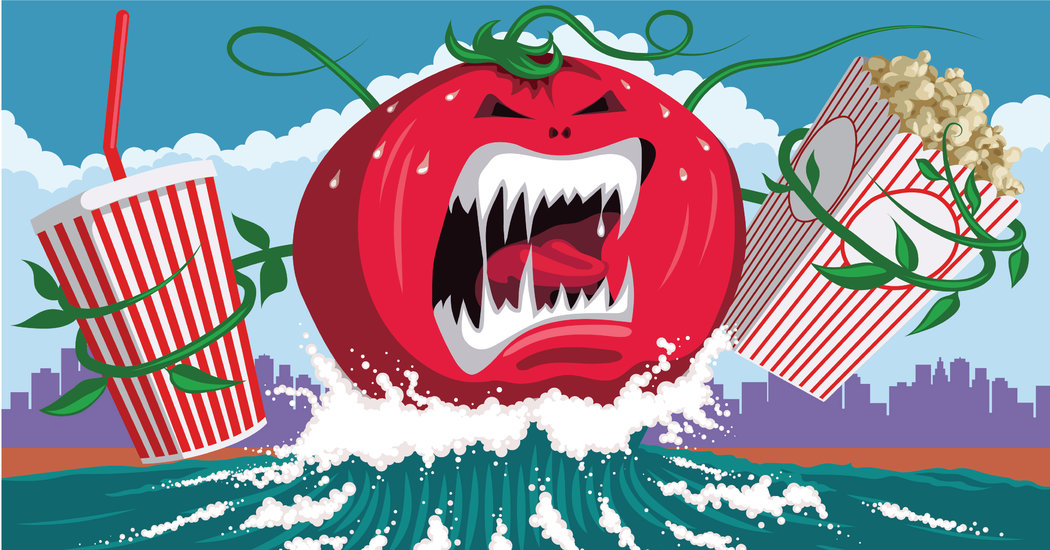

# Movie Analysis from Scraped Rottentomato Data

# Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import gender_guesser.detector as gender

# Statistical Test
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Analysis

## Manipulating and Cleaning the Review Text data

In [2]:
df_critics = pd.read_csv('critic_review.csv')

In [3]:
d = gender.Detector()

first_names = df_critics.critic_name.str.split(' ', expand = True)[0].tolist()

# infer the gender of the critics using their last name
sex = []
for name in first_names:
    gender = d.get_gender(name)
    sex.append(gender)

df_critics['gender'] = sex

In [4]:
df_critics.gender.value_counts()

male             3680
female            888
unknown           322
mostly_male       243
mostly_female     106
andy               22
Name: gender, dtype: int64

In [5]:
df_critics.gender = df_critics.gender.replace('mostly_male', 'male').replace('mostly_female', 'female')
df_critics.head()

,company,critic_name,movie,rating,review_text,gender
0,TheWrap,Leah Rozen,Cars 2,rotten,"don't tell the kids, but santa claus isn't rea...",female
1,Time Out,Derek Adams,Cars 2,rotten,"time, perhaps, for the franchise to be towed o...",male
2,Newsday,Rafer Guzman,Cars 2,fresh,"it's an example of what a sequel should, or at...",unknown
3,Christian Science Monitor,Peter Rainer,Cars 2,fresh,cars 2 is marginally better than its predecess...,male
4,New York Magazine/Vulture,Logan Hill,Cars 2,rotten,...by pixar's outrageous standards of oscar sh...,male


## Exploratory Data Analysis

In [6]:
# Read the dataframe without review text data
df = pd.read_csv('movie_review.csv',
                 index_col=['movie'], parse_dates=['year']).sort_values('year')

In [7]:
# Turn the character gender variable into a categorical variable
df.Char_gender = df.Char_gender.astype('category')

In [8]:
df
df.info()

,audience_prop,critic_prop,critic_score,audience_score,num_audience,num_critic,gross,year,Char_gender
movie,,,,,,,,,
Toy Story,0.92,1.00,4.51,3.75,1109209,84,395253600,1995-11-22,Male
A Bug's Life,0.72,0.92,3.95,3.74,982181,87,307560900,1998-11-20,Male
Toy Story 2,0.86,1.00,4.17,4.34,999689,169,431007100,1999-11-19,Female
"Monsters, Inc.",0.90,0.96,4.02,3.80,1254638,195,406243900,2001-11-02,Male
Finding Nemo,0.86,0.99,4.35,3.81,33356856,263,507600600,2003-05-30,Male
The Incredibles,0.75,0.97,4.17,3.44,32604129,242,378689900,2004-11-05,Male
Cars,0.79,0.75,3.46,3.96,877724,200,335753800,2006-06-09,Male
Ratatouille,0.87,0.96,4.24,4.13,1071723,249,270359800,2007-06-29,Male
WALL-E,0.90,0.95,4.27,4.30,597664,255,280850000,2008-06-27,Male


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, Toy Story to Toy Story 4
Data columns (total 9 columns):
audience_prop     21 non-null float64
critic_prop       21 non-null float64
critic_score      21 non-null float64
audience_score    21 non-null float64
num_audience      21 non-null int64
num_critic        21 non-null int64
gross             21 non-null int64
year              21 non-null datetime64[ns]
Char_gender       21 non-null category
dtypes: category(1), datetime64[ns](1), float64(4), int64(3)
memory usage: 1.6+ KB


In [9]:
df.describe()

,audience_prop,critic_prop,critic_score,audience_score,num_audience,num_critic,gross
count,21.00000,21.000000,21.000000,21.000000,2.100000e+01,21.000000,2.100000e+01
mean,0.82000,0.890000,3.951905,3.969524,3.611516e+06,244.666667,3.421483e+08
std,0.11158,0.150566,0.449918,0.420303,9.774727e+06,78.253008,1.214541e+08
min,0.49000,0.380000,3.050000,2.740000,1.722900e+04,84.000000,1.276513e+08
25%,0.76000,0.800000,3.480000,3.750000,1.033550e+05,200.000000,2.703598e+08
50%,0.86000,0.960000,4.160000,3.980000,5.976640e+05,243.000000,3.357538e+08
75%,0.90000,0.980000,4.270000,4.290000,1.071723e+06,303.000000,4.062439e+08
max,0.94000,1.000000,4.510000,4.590000,3.335686e+07,369.000000,5.973562e+08


* Mean critic score is very close to mean audience score
* Mean gross revenue for Pixar adjusted for ticket price inflation within US is __$342M__.

In [10]:
df2 = df.copy()

In [11]:
df2['Month'] = df2['year'].dt.month
df2['day_of_week'] = df2['year'].dt.dayofweek
df2.head()

,audience_prop,critic_prop,critic_score,audience_score,num_audience,num_critic,gross,year,Char_gender,Month,day_of_week
movie,,,,,,,,,,,
Toy Story,0.92,1.00,4.51,3.75,1109209,84,395253600,1995-11-22,Male,11,2
A Bug's Life,0.72,0.92,3.95,3.74,982181,87,307560900,1998-11-20,Male,11,4
Toy Story 2,0.86,1.00,4.17,4.34,999689,169,431007100,1999-11-19,Female,11,4
"Monsters, Inc.",0.90,0.96,4.02,3.80,1254638,195,406243900,2001-11-02,Male,11,4
Finding Nemo,0.86,0.99,4.35,3.81,33356856,263,507600600,2003-05-30,Male,5,4


In [12]:
df2.Month.value_counts()

6     12
11     7
5      2
Name: Month, dtype: int64

In [13]:
# Pie Chart to visualize number of movies released in particular months

fig = {
    'data': [
        dict(
            labels = ['May', 'June', 'November'],
            values = [2,11,8],
            type = 'pie',
            sort = False,
            hoverinfo = 'label+percent',
            textinfo = 'value'
        )
],
    'layout' : 
        dict(
            title = 'Number of Movies Released in Particular Months'
    )
}

iplot(fig)

* It appears that Pixar only released its movies on __May__, __June__, and __November__.
* As an animation company, it makes sense to release movies during May and June, <br> when students are out of schools and parents are more likely to be on vacation. 

In [14]:
df2.day_of_week.value_counts()

4    18
2     3
Name: day_of_week, dtype: int64

In [15]:
# Pie Chart to visualize number of movies released in particular day of week

fig = {
    'data': [
        dict(
            labels = ['Tuesday', 'Thursday'],
            values = [3, 18],
            type = 'pie',
            sort = False,
            hoverinfo = 'label+percent',
            textinfo = 'value'
        )
],
    'layout' : 
        dict(
            title = 'Number of Movies Released in Particular Days of Week'
    )
}

iplot(fig)

* Considering the fact that most would choose to release their movies on Fridays for obvious reasons, Pixar chose to release the majority of its movies on Thursday because of the following speculations:
    1. With such high reputation as a company, Pixar is able to __maintain high admission rate__ even on a Thursday.
    2. __Fans would most likely book tickets for the first day anyways__, leaving more seats for others throughout the weekend.
    3. __Momentum__ (e.g. media coverage and audience feedback) could be built to further drive weekend admission.

In [16]:
# Line plot to visualize critic score and audience score trends

trace0 = go.Scatter(
    x = df.year,
    y = df.critic_score,
    mode = 'lines+markers',
    name = 'Critic Score',
    text = df.index
)

trace1 = go.Scatter(
    x = df.year,
    y = df.audience_score,
    mode = 'lines+markers',
    name = 'Audience Score',
    text = df.index
)

layout = dict(
    title = 'Mean Critic and Audience scores of all Pixar Movies Across Years',
    xaxis = dict(title = 'Year'),
    yaxis = dict(title = 'Scores (Max = 5)')
)

data = [trace0, trace1]
fig = dict(data=data, layout=layout)

iplot(fig)

* __Toy Story 4__ and __Cars 2__ was the most and least favored movie by general audience, respectively.
* On the other hand, __Toy Story__ and __Cars 3__ was the most and least favored movie by critics, respectively.
* The shapes of the two lines are fairly similar.

In [17]:
# Bar plot to visualize gross revenue

df1 = df.sort_values('gross', ascending=False)

data = [go.Bar(
            x = df1.index,
            y = df1.gross,
            hoverinfo = 'y'
)]

layout = dict(
    title = 'Gross Revenue Adjusted for Inflation for all Pixar Movies (in Million USD)',
    yaxis = dict(title = 'Gross Revenue (USD)')
)

fig = dict(data=data, layout=layout)
iplot(fig)

* The most successful movies were __Incredibles 2__, __Finding Nemo__ and __Finding Dory__.
* The least successful movies were __The Good Dinosaur__, __Cars 3__ and __Coco__.
* __Toy Story 4__ is still on air during data collection.

In [18]:
df.Char_gender.value_counts()

Male      15
Female     6
Name: Char_gender, dtype: int64

In [19]:
# Bar plot to visualize protagonist gender distribution

fig = {
    'data': [
        dict(
            labels = ['Male', 'Female'],
            values = [15, 6],
            type = 'pie',
            sort = False,
            hoverinfo = 'label+percent',
            textinfo = 'value',
            marker = dict(colors = ['skyblue', 'red'])
        )
],
    'layout' : 
        dict(
            title = 'Protagonist Gender Distribution'
    )
}

iplot(fig)

* __(Highly Debatable)__ There were six movies that featured female protagonists to a greater extent, <br> where they generally had more screen time and were major leading characters.
    1. Toy Story 2 (1999)
    2. Brave (2012)
    3. Inside Out (2015)
    4. Finding Dory (2016)
    5. Incredibles 2 (2018)
    6. Toy Story 4 (2019)

In [20]:
df3 = df.groupby('Char_gender')['critic_score', 'audience_score', 'gross'].agg('mean')

In [21]:
df3.gross = df3.gross / 100000000

In [22]:
# Bar plot to visualize mean scores and gross by gender of protagonist

trace1 = go.Bar(
    x = df3.index,
    y = df3.critic_score,
    name = 'Critic Score'   
)

trace2 = go.Bar(
    x = df3.index,
    y = df3.audience_score,
    name = 'Audience Score'   
)

trace3 = go.Bar(
    x = df3.index,
    y = df3.gross,
    name = 'Gross Revenue ($100M USD)'   
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode = 'group',
    title = 'Mean scores and Gross Revenue Stratified by Gender of Protagonist'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

* Both __mean critic score__ and __mean audience score__ were lowered for movies featuring male protagonists to a greater extent, albeit __only little difference__.
* Mean gross revenues were lowered for movies featuring male protagonists by almost $100M USD. <br> This is because __Finding Dory__ and __Incredibles 2__ were two big hits that featured female protagonists to a greater extent.

## Further Analysis

### Statistics and Correlations

In [23]:
# Pairwise T-test for critic and audience score

stats.ttest_rel(df.critic_score, df.audience_score)

Ttest_relResult(statistic=-0.1953261443189248, pvalue=0.8471083530833678)

* A pairwise t-test was conducted to check if the mean critic score and mean audience score for each movie are the same. <br> The result revealed that there was no statistically significantly difference between the two (p = 0.8471).

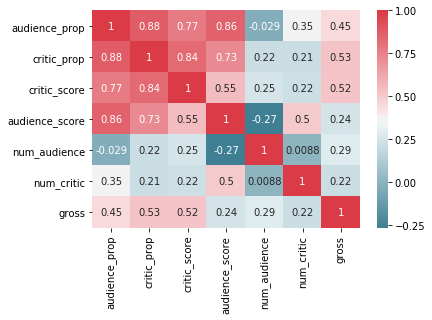

In [24]:
# Correlation Heatmap to visualize linear relationships between variables

sns.heatmap(df.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot = True)

1. There seems to be a relatively strong positive correlation between critic scores and gross revenue.
2. The audience score tends to decrease as the number of audience ratings increase.
    * The driving forces are The Incredibles and Finding Nemo; they both had considerably lower audience scores (3.44 and 3.81 respectively). <br> The two movies had >30M audience reviews, which are 27 times more than the 3rd most reviewed movie, Monster Inc.

In [25]:
# Create Regression Line for Scatterplot

xi = df.critic_score
y = df.gross

slope, intercept, r_value, p_value, std_err = stats.linregress(xi, y)
line = slope*xi+intercept

In [26]:
# Create Scatterplot

trace0 = go.Scatter(
    x = df.critic_score,
    y = df.gross,
    mode = 'markers',
    text = df.index
)

trace1 = go.Scatter(
    x = xi,
    y = line,
    mode = 'lines'
)

layout = go.Layout(
    showlegend = False,
    title = 'Correlation between Critic Score and Gross Revenue (in Million USD)',
    xaxis = dict(title = 'Critic Score'),
    yaxis = dict(title = 'Gross Revenue (USD)'),
    annotations = [
        dict(
            x = 3.3,
            y = 450000000,
            text = '$Adjusted R^2 = 0.235, Y = 141X - 216$',
            showarrow = False,
            font=dict(
                size=25,
                color = 'red'
            )
        )
    ]
)

data = [trace0, trace1]
fig = dict(data=data, layout=layout)

iplot(fig)

* An increase in critic score by __0.1 point__ is associated with __$14.1M (USD) increase__ in gross revenue for Pixar.
* Only 23.5% of the variability in our data is explained by the model.
* It suggested that general audience might consult the mean critic score of a Pixar movie before making the decision of whether to go to the cinema or not.
* On the contrary, it could be that the critic scores were influenced by the popularity of the movies.
* It could be difficult to tell between the above two scenarios because of the temporal variability in critic score entry.

$Adjusted R^2 = 0.235, \quad P = 0.01496$

### Bias Investigation

#### Company Where the Critics Worked for

In [27]:
# Compute proportions of good reviews given by each company

# Filter out companies with less than 15 reviews
df4 = df_critics.groupby('company').filter(lambda x: len(x) >=15)
df6 = pd.DataFrame(df4.company.value_counts())
df5 = df4.groupby(['company', 'rating'], sort = False)[['movie']].count()

# Slice index with good ratings
df5 = df5.xs('fresh', level='rating')
df5 = df5.reset_index()
df6 = df6.reset_index()
df5.columns = ['company', 'num_fresh']
df6.columns = ['company', 'num_total']
df7 = pd.merge(df5, df6, on = 'company')
df7 = df7.sort_values('num_total', ascending=False)
df7['prop_fresh'] = df7.num_fresh / df7.num_total
df7 = df7.sort_values('prop_fresh').iloc[:, [0,3]]

In [28]:
# Boxplot to determine distribution of good reviews proportions

trace = go.Box(
    y = df7.prop_fresh,
    boxpoints = 'suspectedoutliers',
    text = df7.company,
    marker = dict(
        color = 'rgb(8,81,156)',
        outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            outlierwidth = 2)),
    line = dict(
        color = 'rgb(8,81,156)'),
    boxmean = True
)

layout = go.Layout(
    title = 'Distribution of Good Reviews Proportion of each Company'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

* Mean and median good reviews proportion were 0.89 and 0.90 respectively; the critics do love Pixar in general!
* We will further inspect the outlier and the companies that give unanimous good ratings for Pixar.

In [29]:
# Inspect the companies that tend to give extreme ratings

companies_to_investigate = df7.loc[(df7.prop_fresh < 0.65) | (df7.prop_fresh == 1), :].company.tolist()
df8 = df_critics.loc[df_critics.company.isin(companies_to_investigate), :].sort_values('company')

In [30]:
companies_to_investigate

['Globe and Mail',
 'Empire Magazine',
 'Entertainment Weekly',
 'St. Paul Pioneer Press',
 'Movie Metropolis',
 'Daily Telegraph (UK)',
 'Common Sense Media',
 'Laramie Movie Scope',
 'Arizona Republic',
 'IGN Movies',
 'Seattle Times',
 'Rolling Stone',
 'rachelsreviews.net',
 'New York Daily News',
 'Reel.com',
 'Christian Science Monitor',
 'Jam! Movies',
 'Total Film',
 'Radio Times']

In [31]:
df8[df8.company == 'Globe and Mail']

,company,critic_name,movie,rating,review_text,gender
1937,Globe and Mail,Leah McLaren,The Incredibles,fresh,not only is this a rollicking cartoon joy ride...,female
3114,Globe and Mail,Liam Lacey,Inside Out,fresh,"inside out is imaginative and ambitious, even ...",male
1228,Globe and Mail,Liam Lacey,WALL-E,fresh,mixing chaplinesque delicacy with the architec...,male
82,Globe and Mail,Kate Taylor,Coco,fresh,none of coco's few flaws can fatally undermine...,female
4388,Globe and Mail,John Semley,The Good Dinosaur,rotten,the digital landscapes are meant to be breatht...,male
4411,Globe and Mail,Kate Taylor,Cars 3,rotten,we get a lot of repetitive racetrack scenes - ...,female
4513,Globe and Mail,Liam Lacey,Brave,rotten,"what we get would be fine from another studio,...",male
3463,Globe and Mail,Barry Hertz,Toy Story 4,fresh,the visuals are so impressive that i reached t...,male
953,Globe and Mail,Barry Hertz,Incredibles 2,rotten,"big, annoying and mostly, pointless.",male
4266,Globe and Mail,Liam Lacey,Cars 2,rotten,"unlike most pixar fare, this isn't a movie you...",male


* Visual inspection reveals that Globe and Mail's review aligns generally well with other critics and audience. Their reviewers are just being more critical.

In [32]:
# Get the names of the companies 

worst_movie = ['Cars 2', 'Cars 3', 'The Good Dinosaur']
df8[df8.movie.isin(worst_movie)].groupby('company').filter(lambda x: len(x) >= 3).company.unique().tolist()

['Arizona Republic',
 'Christian Science Monitor',
 'Common Sense Media',
 'Daily Telegraph (UK)',
 'Empire Magazine',
 'Entertainment Weekly',
 'Globe and Mail',
 'IGN Movies',
 'Radio Times',
 'Seattle Times']

* The above 10 companies __gave good reviews even for the three most badly reviewed movies__ (Cars 2, Cars 3 and The Good Dinosaur). <br> Although there exists no evidence of them deliberately altering reviews in favor of Pixar, __we can be more skeptical about their reviews__ in the future.

#### Gender of the critics

In [33]:
df9 = df_critics.loc[df_critics.gender.isin(['female', 'male'])]

In [34]:
# Pie chart to visualize critics gender distribution

fig = {
    'data': [
        dict(
            labels = ['Male', 'Female'],
            values = [3923, 994],
            type = 'pie',
            sort = False,
            hoverinfo = 'label+value',
            textinfo = 'percent',
            marker = dict(colors = ['skyblue', 'red'])
        )
],
    'layout' : 
        dict(
            title = 'Critics Gender Distribution'
    )
}

iplot(fig)

* There were 3 times more male critic reviews than its female counterpart.
* The result suggested that the critic ratings might reflect upon the male perspective more.

In [35]:
df9.groupby(['gender', 'rating'])['movie'].count()

gender  rating
female  fresh      901
        rotten      93
male    fresh     3528
        rotten     395
Name: movie, dtype: int64

In [36]:
count = np.array([901, 3528])
nobs = np.array([994, 3923])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.502


* A proportional z-test reveals that there is no evidence to believe the existence of a difference in movie rating behaviors between critics of the opposite sex (p = 0.502). This is not surprising because Pixar movies are usually considered relatively gender neutral.

* A potentially more interesting question to ask is if there is any gender bias towards genders of the main protagonists.

In [37]:
# Get character gender info into the critics dataframe

character_gender = df['Char_gender']
character_gender_dict = character_gender.to_dict()
df_critics['character_gender'] = df_critics['movie'].map(character_gender_dict)

In [38]:
df_critics.loc[df_critics.gender.isin(['female', 'male'])].groupby([
    'gender', 'character_gender', 'rating'])['movie'].count()

gender  character_gender  rating
female  Female            fresh      369
                          rotten      21
        Male              fresh      532
                          rotten      72
male    Female            fresh     1220
                          rotten      82
        Male              fresh     2308
                          rotten     313
Name: movie, dtype: int64

In [39]:
count = np.array([369, 1220])
nobs = np.array([390, 1302])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.508


In [40]:
count = np.array([532, 2308])
nobs = np.array([604, 2621])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.988


* From the two proportional z-tests, there are no evidence of existing gender bias for Pixar movies featuring female protagonists (p = 0.508) and movies featuring male protagonists (p = 0.988) among critics of the opposite sex.

### Text Data

In [41]:
# Grab words according to 'fresh' and 'rotten' reviews
fresh = df_critics.groupby('rating')['review_text'].apply(list)[0]
rotten = df_critics.groupby('rating')['review_text'].apply(list)[1]

freshwords = ','.join(map(str, fresh))
rottenwords = ','.join(map(str, rotten))

# Create stopwords list
stopwords = set(STOPWORDS)
stopwords.update(['movie', 'movies', 'pixar', 'film', 'films',
                  'will', 'still', 'review', 'one', 'animation', 'animated'])

In [42]:
mask = np.array(Image.open("mike.png"))

<Figure size 1080x1080 with 0 Axes>

(-0.5, 490.5, 544.5, -0.5)

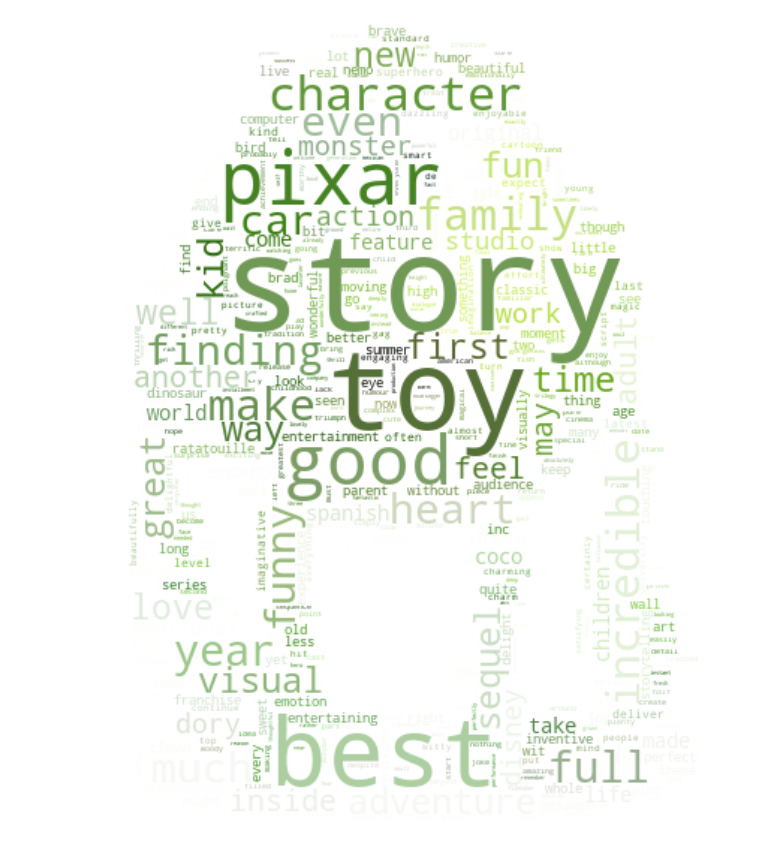

In [43]:
# Create wordcloud rendered in character image

wordcloud_fresh = WordCloud(stopwords=stopwords, background_color="white",
                          mode="RGBA", max_words=1000, mask=mask, collocations=False).generate(freshwords)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_fresh.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('img/fresh.png')

* From the good reviews word cloud, we can see mentions of relevant words such as 'funny', 'family', 'fun', 'best'.
* Movies that were highly praised also appears, such as 'Toy Story' and 'Incredibles'.

In [44]:
mask = np.array(Image.open("jessie.png"))

<Figure size 1080x1080 with 0 Axes>

(-0.5, 1106.5, 2185.5, -0.5)

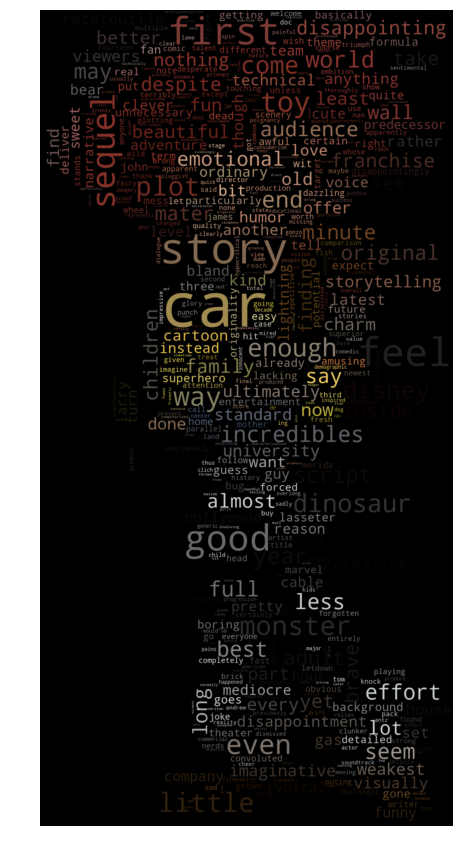

In [45]:
wordcloud_rotten = WordCloud(stopwords=stopwords, background_color="black",
                          mode="RGBA", max_words=1000, mask=mask, collocations=False).generate(rottenwords)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_rotten.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig('img/rotten.png')
plt.show()

* While some of the worse reviewed movies such as 'Monster University' and 'Cars' do show up, some of the adjectives (memorable, charm, etc) fail to align with the negative polarity.
* This is because negation (i.e. 'not memorable', 'less charm') was not taken into account when creating this word cloud.